In [1]:
import sys
sys.path.append("./../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

#
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
#
from effcn.models_mnist import CapsNet, CapsNetCross,EffCapsNetCross, EffCapsNet
from misc.utils import count_parameters, calc_receptive_field, layer_conv, bb_pc_vals, calc_layer_combs, rf_layer_combs
from misc.plot_utils import imshow, plot_mat
from misc.capsule_activations import affine_shear, affine_scale, affine_rot, affine_ytrans, affine_xtrans, plt_lin, calc_pc_corr, calc_pc_delta, show_pc_vals, show_imgrid, cross_correlation, TwinAugmentation

In [4]:
from matplotlib import style

style.use('dark_background')

### Local Func

In [7]:
class TwinAugmentation(nn.Module):
    """
        double random augmentation of a input 
        value example:
        rotade=30, translate=[0.2,0.2], scale=[0.9, 1.1], shear=[-3,3]
    """
    def __init__(self, rotade=None, translate=None, scale=None, shear=None):
        
        super().__init__()
        self.transforms = T.Compose([
                                T.RandomAffine(degrees=rotade,
                                                translate=translate,
                                                scale=scale,
                                                shear=shear),
                                ])
    
    def forward(self, x):
        x1 = self.transforms(x)
        x2 = self.transforms(x)
        return x1, x2

In [8]:
def cross_correlation(X1, X2):
    X1_norm = (X1 - X1.mean(dim=0)) / X1.std(dim=0)
    X2_norm = (X2 - X2.mean(dim=0)) / X2.std(dim=0)

    c = torch.matmul(X1_norm.T, X2_norm) / X1.shape[0]
    return c

### Load Dataset

In [5]:
p_data = '/mnt/data/datasets'

In [6]:
ds = datasets.MNIST(root=p_data, train=False,download=False, transform=T.ToTensor())

In [7]:
bs = 32
shuffle=False
dl = torch.utils.data.DataLoader(ds,batch_size=bs,shuffle=shuffle)

In [8]:
x, y = next(iter(dl))

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


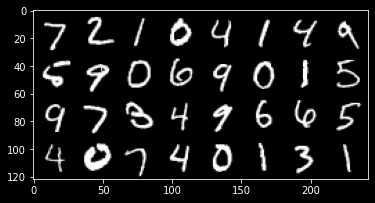

In [9]:
show_imgrid(x,y,nrow=8)

### Load Model

In [10]:
if torch.cuda.is_available():  
    dev = "cuda:0"
else:  
    dev = "cpu"  
device = torch.device(dev)

torch.cuda.current_device()

0

In [11]:
p_model = '/mnt/data/experiments/CN/mnist/mnist_CapsNet_2022_05_17_13_28_17/ckpts/model_150.ckpt'

In [12]:
model = CapsNet()
model.load_state_dict(torch.load(p_model))
model.eval()
model = model.to(device)

### signal correlation

In [18]:
model.eval()

#augmentation = TwinAugmentation(rotade=20, translate=[0.2,0.2], scale=[0.9, 1.1], shear=[-3,3])
#augmentation = TwinAugmentation(rotade=60, translate=[0.4,0.4], scale=[0.7, 1.3], shear=[-6,6])
augmentation = TwinAugmentation(rotade=10, translate=None, scale=None,shear=None)
activations1 = []
activations2 = []
    
i = 0

for x,y_true in dl:
    x = x.to(device)
    x1, x2 = augmentation(x)
        
    with torch.no_grad():
        _, _, u_l1, _ = model.forward_pc_study(x1)
        _, _, u_l2, _ = model.forward_pc_study(x2)
    
    norm1 = torch.norm(u_l1, dim=-1).tolist()
    norm2 = torch.norm(u_l2, dim=-1).tolist()
    
    activations1.extend(norm1)
    activations2.extend(norm2)

activations1 = torch.tensor(activations1).transpose(dim0=1, dim1=0)
activations2 = torch.tensor(activations2).transpose(dim0=1, dim1=0)

cross = cross_correlation(X1=activations1, X2=activations2)

cr_diag = cross.diag()

cr_diag.mean(), cr_diag.std()

(tensor(0.9808), tensor(0.0123))

In [19]:
activations1.shape

torch.Size([1152, 10000])

Variace of augmentations 


rotade=20, translate=[0.2,0.2], scale=[0.9, 1.1], shear=[-3,3]
(torch.Size([1152, 60000, 2]), tensor(0.0156), tensor(0.0414))

rotade=60, translate=[0.4,0.4], scale=[0.7, 1.3], shear=[-6,6]
(torch.Size([1152, 60000, 2]), tensor(0.0186), tensor(0.0443))


rotade=80, translate=[0.4,0.4], scale=[0.5, 1.5], shear=[-8,8]
(torch.Size([1152, 60000, 2]), tensor(0.0195), tensor(0.0457))

#### augmentation

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


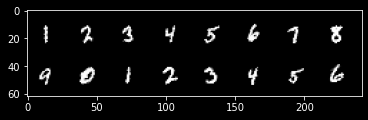

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5],
        [9, 7, 3, 4, 9, 6, 6, 5],
        [4, 0, 7, 4, 0, 1, 3, 1]])


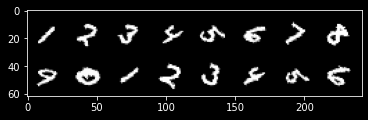

(None, None)

In [14]:
#B = TwinAugmentation(rotade=20, translate=[0.2,0.2], scale=[0.9, 1.1], shear=[-3,3])
#B = augmentation = TwinAugmentation(rotade=60, translate=[0.4,0.4], scale=[0.7, 1.3], shear=[-6,6])
B = augmentation = TwinAugmentation(rotade=80, translate=[0.4,0.4], scale=[0.5, 1.5], shear=[-8,8])


x1, x2 = B(x)

show_imgrid(x1.detach().cpu(),y,nrow=8), show_imgrid(x2.detach().cpu(),y,nrow=8)